In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from typing import List
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from tensorflow import random
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer


RANDOM_STATE: int = 152

In [2]:
samples: pd.DataFrame = pd.read_csv("./data/music_samples.csv")

In [3]:
classic_sample: int = len(samples[samples["IsClassic"] == 1])
not_classic_samples: int = len(samples[samples["IsClassic"] == 0])
classic_sample, not_classic_samples

(92042, 42295)

Our dataset has more classic samples, so we need to downsample it.

In [4]:
classic_music_samples: pd.DataFrame = samples[samples["IsClassic"] == 1].head(not_classic_samples)
not_classic_music_samples: pd.DataFrame = samples[samples["IsClassic"] == 0]
music_data = pd.concat([classic_music_samples, not_classic_music_samples])
music_data

,ChordSeq,DurationSeq,IsClassic
0,rest 2 2|5 9|0|3|5 2|3|5|9 9|0|2|3|5 9|0|2|3|5...,5.5 0.25 0.25 1.0 1/3 1/6 0.75 1/12 1/6 0.5 1....,1
1,2 2|5 9|0|3|5 2|3|5|9 9|0|2|3|5 9|0|2|3|5 9|0|...,0.25 0.25 1.0 1/3 1/6 0.75 1/12 1/6 0.5 1.5 1....,1
2,2|5 9|0|3|5 2|3|5|9 9|0|2|3|5 9|0|2|3|5 9|0|2|...,0.25 1.0 1/3 1/6 0.75 1/12 1/6 0.5 1.5 1.0 0.2...,1
3,9|0|3|5 2|3|5|9 9|0|2|3|5 9|0|2|3|5 9|0|2|3|5 ...,1.0 1/3 1/6 0.75 1/12 1/6 0.5 1.5 1.0 0.25 0.2...,1
4,2|3|5|9 9|0|2|3|5 9|0|2|3|5 9|0|2|3|5 2|3|5|9 ...,1/3 1/6 0.75 1/12 1/6 0.5 1.5 1.0 0.25 0.25 0....,1
...,...,...,...
134332,2|4 9|2 9|2 2 2|4 7|9 7|9 2|7 4|7 7|9 7|9 2|7 ...,0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0...,0
134333,9|2 9|2 2 2|4 7|9 7|9 2|7 4|7 7|9 7|9 2|7 4|7 ...,0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0...,0
134334,9|2 2 2|4 7|9 7|9 2|7 4|7 7|9 7|9 2|7 4|7 6|9 ...,0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0...,0
134335,2 2|4 7|9 7|9 2|7 4|7 7|9 7|9 2|7 4|7 6|9 6|9 ...,0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0...,0


In [5]:
X = music_data[["ChordSeq", "DurationSeq"]]
Y = music_data["IsClassic"]
seq_len: int = len(X["ChordSeq"][0].split())
train_x, test_x, train_y, test_y = train_test_split(X, Y, shuffle=True, random_state=RANDOM_STATE)
tokenizer = Tokenizer(filters="")
tokenizer.fit_on_texts(train_x["ChordSeq"])
train_chord_seq = tokenizer.texts_to_sequences(train_x["ChordSeq"])
test_chord_seq = tokenizer.texts_to_sequences(test_x["ChordSeq"])
train_chord_seq = pad_sequences(train_chord_seq, maxlen=seq_len)
test_chord_seq = pad_sequences(test_chord_seq, maxlen=seq_len)

In [6]:
class DisriminatorMusicModel:
    def __init__(self, seq_len: int, chords_vocab_size: int):
        random.set_seed(RANDOM_STATE)
        i = Input(shape=seq_len)
        x = Embedding(chords_vocab_size + 1, 50)(i)
        x = LSTM(128, return_sequences=True)(x)
        x = LSTM(256, return_sequences=True)(x)
        x = GlobalMaxPooling1D()(x)
        x = Dense(1, activation="sigmoid")(x)
        self._model = Model(i, x)

    def fit(self, train_chord_seq: List[str], train_y: np.array, test_chord_seq: List[str], test_y: np.array, epochs: int):
        self._model.compile(loss="binary_crossentropy", optimizer="adam", metrics="accuracy")
        return self._model.fit(train_chord_seq, train_y, epochs=epochs, validation_data=(test_chord_seq, test_y))

    def predict(self, chords: List[str]) -> float:
        return self._model.predict(np.array([chords]))

    def serialize(self, path: str):
        self._model.save(path)

In [7]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
config = tf.config.experimental.set_memory_growth(physical_devices[0], True)
disc_music_model: DisriminatorMusicModel = DisriminatorMusicModel(seq_len, len(tokenizer.word_index))
history = disc_music_model.fit(train_chord_seq, train_y.to_numpy(), test_chord_seq, test_y.to_numpy(), 2)

Epoch 1/2
1983/1983 [==============================] - 32s 16ms/step - loss: 0.0623 - accuracy: 0.9760 - val_loss: 0.0171 - val_accuracy: 0.9947
Epoch 2/2
1983/1983 [==============================] - 31s 16ms/step - loss: 0.0079 - accuracy: 0.9973 - val_loss: 0.0014 - val_accuracy: 0.9999


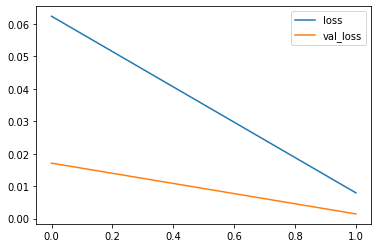

In [8]:
pyplot.plot(history.history["loss"], label="loss")
pyplot.plot(history.history["val_loss"], label="val_loss")
pyplot.legend()

In [9]:
disc_music_model.serialize("./models/discriminator.mdl")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./models/discriminator.mdl/assets
